In [1]:
from sklearn.metrics import *
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
import pandas as pd
import numpy as np
from svm import SVM
from naivebayes import NaiveBayes

In [2]:
df = pd.read_csv('../datasets/heart.csv')

In [3]:
X = df.iloc[:,0:-1].values
y = df.iloc[:,-1].values

In [4]:
X_train, X_test, y_train, y_test = train_test_split(X,y,stratify=y,train_size=0.8)

In [5]:
res = {}

# Avaliando as classes que criamos

## Naive Bayes

In [6]:
naive_bayes = NaiveBayes()
naive_bayes.fit(X_train, y_train)

In [7]:
y_pred = naive_bayes.predict(X_test)

In [8]:
res['NaiveBayes'] = f1_score(y_pred=y_pred, y_true=y_test)

## SVM

In [9]:
svm = SVM()

In [10]:
svm.fit(X_train, y_train)

In [11]:
y_pred = svm.predict(X_test)

In [13]:
res['svm'] = f1_score(y_pred=y_pred, y_true=y_test)

# Avaliando GaussianNB e SVC do Sklearn com gridsearch

In [14]:
params = [
  {
    "est__var_smoothing": [1e-11,1e-10,1e-9,1e-8,1e-7],
    "est": [GaussianNB()]
  },
  {
    "est__C": np.linspace(0.1,1.9,10),
    'est__gamma': np.linspace(1e-5,1,10),
    'est__kernel': ['rbf','poly','sigmoid','linear'],
    'est__random_state': [42],
    "est": [SVC()]
  },
]

In [15]:
pipe = Pipeline([
  ('pre', ColumnTransformer([
    ('std', StandardScaler(), [x for x in range(13)])
  ])),
  ('est', None)
])

In [16]:
grid_search = GridSearchCV(pipe, params, scoring='f1', cv=3, n_jobs=-1, return_train_score=True)

In [17]:
%%time
%%capture
grid_search.fit(X_train, y_train)

CPU times: user 1.06 s, sys: 64.9 ms, total: 1.12 s
Wall time: 8.01 s


In [18]:
y_pred = grid_search.predict(X_test)

In [19]:
f1_score(y_pred=y_pred, y_true=y_test)

1.0

In [20]:
res_gs = pd.DataFrame(grid_search.cv_results_)

In [21]:
res_gs['model'] = res_gs['param_est'].astype(str).str.split('(',1,True)[0]

In [22]:
best_of_each = res_gs.groupby('model')['rank_test_score'].idxmin()

In [23]:
res_gs.iloc[best_of_each]

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_est,param_est__var_smoothing,param_est__C,param_est__gamma,param_est__kernel,param_est__random_state,...,split2_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,mean_train_score,std_train_score,model
0,0.003242,0.000056,0.002775,0.000666,GaussianNB(),0.0,NaN,NaN,NaN,NaN,...,0.845070,0.843232,0.008385,273,0.846847,0.837607,0.866328,0.850261,0.011971,GaussianNB
301,0.015630,0.000353,0.010247,0.000414,"SVC(C=1.5, gamma=0.44445, random_state=42)",NaN,1.5,0.44445,rbf,42,...,0.970149,0.971233,0.011239,1,1.000000,1.000000,1.000000,1.000000,0.000000,SVC


In [24]:
res['GaussianNB'] = res_gs.iloc[best_of_each['GaussianNB'],19]
res['SVC'] = res_gs.iloc[best_of_each['SVC'],19]

# Comparando resultados

In [25]:
res

{'NaiveBayes': 0.8279069767441859,
 'svm': 0.7046979865771812,
 'GaussianNB': 0.8663282571912013,
 'SVC': 1.0}

In [26]:
df_res = pd.DataFrame.from_dict(res, orient='index')

<AxesSubplot:>

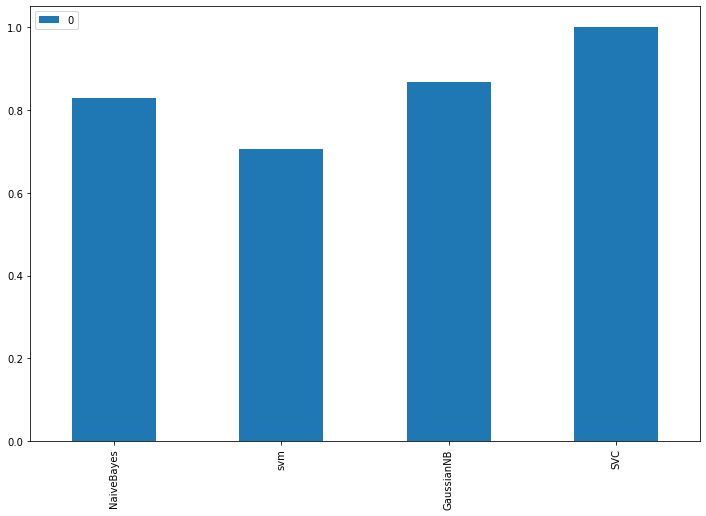

In [27]:
df_res.plot(kind='bar', figsize=(12,8))